# Using Supervised Machine Learning Algorithms For Drug Target Interaction Prediction
DOI: 10.1109/ASYU56188.2022.9925433

In [ ]:
# pip install pandas

In [ ]:
# pip install networkx

In [ ]:
# pip install node2vec

In [ ]:
import networkx as nx
import pandas as pd

In [ ]:
dataset = pd.read_csv('KIBA_binarized.csv')
dataset = pd.read_csv('https://raw.githubusercontent.com/BrunoAGSa/SIB_Work/main/KIBA_binarized.csv?token=GHSAT0AAAAAACHXL6AA4RTS4NK5DGDBYIJ4ZM2BDMQ')
dataset = dataset.drop(['Drug', 'Target'], axis=1)
dataset

,Drug_ID,Target_ID,Y
0,CHEMBL1087421,O00141,0
1,CHEMBL1087421,O14920,0
2,CHEMBL1087421,O15111,0
3,CHEMBL1087421,P00533,0
4,CHEMBL1087421,P04626,0
...,...,...,...
117652,CHEMBL230654,Q13554,0
117653,CHEMBL230654,Q13555,0
117654,CHEMBL230654,Q13557,0
117655,CHEMBL230654,Q16539,0


In [ ]:
#perform downsampling
from sklearn.utils import resample
dataset_majority = dataset[dataset.Y==0]
dataset_minority = dataset[dataset.Y==1]

dataset_majority_downsampled = resample(dataset_majority,
                                        replace=False,
                                        n_samples=dataset_minority.shape[0],
                                        random_state=123)

dataset_downsampled = pd.concat([dataset_majority_downsampled, dataset_minority])
print(dataset_downsampled.Y.value_counts())
dataset_downsampled

0    22566
1    22566
Name: Y, dtype: int64


,Drug_ID,Target_ID,Y
74998,CHEMBL1988995,Q86V86,0
4492,CHEMBL117697,P51812,0
50533,CHEMBL1999321,Q9H2G2,0
97440,CHEMBL1994361,P51955,0
106613,CHEMBL2001987,P50613,0
...,...,...,...
117638,CHEMBL307152,Q13554,1
117639,CHEMBL307152,Q13555,1
117640,CHEMBL307152,Q13557,1
117643,CHEMBL307152,Q9UQM7,1


In [ ]:
dataset['Y'] = dataset['Y'].astype(int)

# Initialize graph
G = nx.Graph()

# Add nodes and edges to the graph
G.add_nodes_from(dataset['Drug_ID'], bipartite=0)
G.add_nodes_from(dataset['Target_ID'], bipartite=1)
G.add_edges_from([(row['Drug_ID'], row['Target_ID'], {'Y': row['Y']}) for _, row in dataset.iterrows()])

In [ ]:
#build graph

#G = nx.Graph()
#G.add_nodes_from(dataset['Drug_ID'], bipartite=0)
#G.add_nodes_from(dataset['Target_ID'], bipartite=1)
#G.add_edges_from([(row['Drug_ID'], row['Target_ID']) for _, row in dataset.iterrows()])

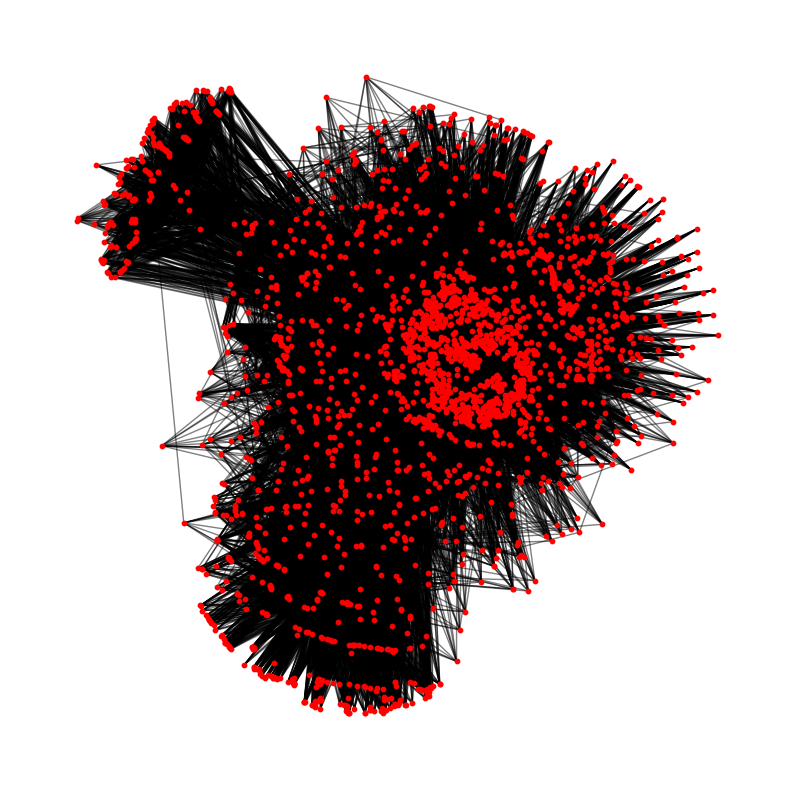

In [ ]:
#draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='red')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
plt.axis('off')
plt.show()

In [ ]:
#Embedding with Node2Vec
from node2vec import Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

In [ ]:
#extract all embeddings
all_embeddings = {node: model.wv[node] for node in G.nodes}
all_embeddings

In [ ]:
import numpy as np

feature_matrix = np.array([np.concatenate((all_embeddings[node1], all_embeddings[node2])) for node1, node2 in G.edges])
feature_matrix

array([[-0.28278223, -0.56127733, -0.20453633, ..., -0.6430414 ,
         0.19353308, -0.20749806],
       [-0.28278223, -0.56127733, -0.20453633, ...,  0.04965927,
         0.20650138, -0.13456394],
       [-0.28278223, -0.56127733, -0.20453633, ..., -0.02628632,
         0.44789523, -0.555712  ],
       ...,
       [-0.5269742 ,  0.13537377, -0.4344333 , ...,  0.36643085,
         0.03091881, -0.09065338],
       [-0.5269742 ,  0.13537377, -0.4344333 , ..., -0.1068992 ,
        -0.20540398, -0.43208283],
       [-0.5269742 ,  0.13537377, -0.4344333 , ...,  0.24610622,
         0.06067908, -0.49599347]], dtype=float32)

In [ ]:
def your_label_function(node1, node2):
    # Assuming your Y column contains 0s and 1s
    # You might have a more complex condition based on your specific task
    return G[node1][node2]['Y']

labels = [your_label_function(node1, node2) for node1, node2 in G.edges]
len(labels)

117657

In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42)

# Choose a machine learning model (Random Forest as an example)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Make predictions on the test set
predictions = model_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Print classification report for more detailed evaluation
print("Classification Report:\n", classification_report(y_test, predictions))

# calculate the AUROC
predictions = model_rf.predict_proba(X_test)
predictions = predictions[:, 1]
print("AUROC for Random Forest:", roc_auc_score(y_test, predictions))

Accuracy: 0.8751487336392997
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     19017
           1       0.85      0.43      0.57      4515

    accuracy                           0.88     23532
   macro avg       0.86      0.70      0.75     23532
weighted avg       0.87      0.88      0.86     23532

AUROC for Random Forest: 0.9013790656852985


In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

predictions = model_lr.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, predictions))

# calculate the AUROC
predictions = model_lr.predict_proba(X_test)
predictions = predictions[:, 1]
print("AUROC for LogisticRegression:", roc_auc_score(y_test, predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8240693523712391
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90     19017
           1       0.66      0.17      0.27      4515

    accuracy                           0.82     23532
   macro avg       0.75      0.57      0.58     23532
weighted avg       0.80      0.82      0.78     23532

AUROC for LogisticRegression: 0.7364838862191904


In [ ]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)

predictions = model_knn.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, predictions))

# calculate the AUROC
predictions = model_knn.predict_proba(X_test)
predictions = predictions[:, 1]
print("AUROC for Kneighbors:", roc_auc_score(y_test, predictions))

Accuracy: 0.8229219785823559
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     19017
           1       0.55      0.39      0.46      4515

    accuracy                           0.82     23532
   macro avg       0.71      0.66      0.68     23532
weighted avg       0.81      0.82      0.81     23532

AUROC for Kneighbors: 0.7324357858746307


In [ ]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

predictions = model_dt.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, predictions))

# calculate the AUROC
predictions = model_dt.predict_proba(X_test)
predictions = predictions[:, 1]
print("AUROC for DecisionTreeClassifier:", roc_auc_score(y_test, predictions))

Accuracy: 0.8233894271630121
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     19017
           1       0.54      0.55      0.54      4515

    accuracy                           0.82     23532
   macro avg       0.72      0.72      0.72     23532
weighted avg       0.82      0.82      0.82     23532

AUROC for DecisionTreeClassifier: 0.7178607984427992


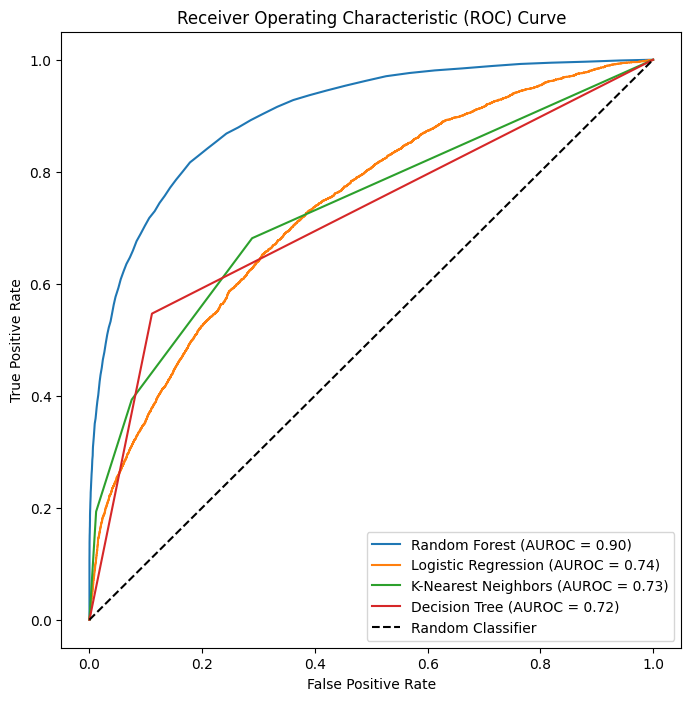

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have predictions for each model
predictions_rf = model_rf.predict_proba(X_test)[:, 1]
predictions_lr = model_lr.predict_proba(X_test)[:, 1]
predictions_knn = model_knn.predict_proba(X_test)[:, 1]
predictions_dt = model_dt.predict_proba(X_test)[:, 1]

# Calculate ROC curves and AUROC scores
fpr_rf, tpr_rf, _ = roc_curve(y_test, predictions_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, predictions_lr)
fpr_knn, tpr_knn, _ = roc_curve(y_test, predictions_knn)
fpr_dt, tpr_dt, _ = roc_curve(y_test, predictions_dt)

auroc_rf = auc(fpr_rf, tpr_rf)
auroc_lr = auc(fpr_lr, tpr_lr)
auroc_knn = auc(fpr_knn, tpr_knn)
auroc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUROC = {auroc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUROC = {auroc_lr:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (AUROC = {auroc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUROC = {auroc_dt:.2f})')

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()